# Calculate ${R^2}$ using the whole validation set
Since R2 is more intuitive in the geochemistry filed, I'll calculate both standardize and log transform models' R2. They all use the modified loss function (include both masked and unmasked spectrum). Meanwhile, comparing to using a single spectrum in `pilot_09.ipynb`, this notebook intends to use the whole validation set to evaluate the model performance, which should be more robust.

In [1]:
import torch
from test_loss import get_dataloader, evaluate
from util.datasets import standardize, log_transform
from models_mae_loss import mae_vit_base_patch16
import matplotlib.pyplot as plt
import numpy as np

## Normalized spaces
We first calculate the R2 in each normalized space.

#### Function
This is the function to evaluate the baseline model, i.e. the model that predicts the mean of the dataset. The loss of this model is equivalent to the variance of the dataset. Apart from this way of calculation (calculating the whole dataset at once), I have tried to calculate the loss in each batch and then average them. However, the results are almost the same.

In [7]:
def evaluate_base(dataloader):
    data = torch.empty((0, 2048))

    with torch.no_grad():
        for samples in dataloader:
            data = torch.cat((data, samples), 0)
        mean = data.mean()
        loss = (data-mean)**2
        loss = loss.mean()
    return loss.item()

    #total_loss = 0.
    #with torch.no_grad():
    #    for samples in dataloader:
    #        mean = samples.mean(dim=1, keepdim=True)
    #        loss = (mean - samples)**2
    #        loss = loss.mean()
    #        total_loss += loss.item()
    #retrun total_loss / len(dataloader['val'])

### Standardized data

In [176]:
dataloader = get_dataloader(batch_size=64, transform=standardize)
model = mae_vit_base_patch16().to('cuda')
model.load_state_dict(torch.load('models/mae_vit_base_patch16_std_1e-05_20231212.pth'))

model_mse = evaluate(model, dataloader['val'])
print(round(model_mse, 4))

base_mse = evaluate_base(dataloader['val'])
print(round(base_mse, 4))

print(f'R2: {round(1 - model_mse / base_mse, 2)}')

0.008
1.0
R2: 0.99


### Log transform data

In [177]:
dataloader = get_dataloader(batch_size=64, transform=log_transform)
model = mae_vit_base_patch16().to('cuda')
model.load_state_dict(torch.load('models/mae_vit_base_patch16_ln_0.0001_20231212.pth'))

model_mse = evaluate(model, dataloader['val'])
print(round(model_mse, 4))

base_mse = evaluate_base(dataloader['val'])
print(round(base_mse, 4))

print(f'R2: {round(1 - model_mse / base_mse, 2)}')

0.0467
8.5319
R2: 0.99


Both perform excellent in their own normalized space. 
## Original spaces
Then we calculate the R2 in the original space.

In [3]:
def inverse_standardize(raws, pred_un):
    mean = raws.mean(dim=1, keepdim=True)
    std = raws.std(dim=1, keepdim=True)
    return pred_un * std + mean

def inverse_log(raws, pred_un):
    # raws is not used, just to be consistent with other inverse functions
    return torch.exp(pred_un) - 1

def get_mse(true_values, pred_values):
    # all in tensor
    loss = (true_values - pred_values)**2
    loss = loss.mean()
    return loss.item()

def evaluate_inraw(model, dataloader_raw, dataloader_norm, inverse=None, device='cuda'):
    total_loss = 0.
    model.eval()  # turn on evaluation mode

    with torch.no_grad():
        for (raws, norms) in zip(dataloader_raw, dataloader_norm):
            raws = raws.to(device, non_blocking=True, dtype=torch.float)
            norms = norms.to(device, non_blocking=True, dtype=torch.float)

            _, pred, _ = model(norms)    # in normalized space
            pred_un = model.unpatchify(pred)
            if inverse:
                pred_un = inverse(raws, pred_un)    # in raw space
            loss = get_mse(raws, pred_un)
            total_loss += loss
    return total_loss / len(dataloader_raw)

In [14]:
# the base model
dataloader_raw = get_dataloader(batch_size=64, transform=None)
mse_base = evaluate_base(dataloader_raw['val'])

# the first model without converging
model = mae_vit_base_patch16().to('cuda')
model.load_state_dict(torch.load('models/mae_vit_base_patch16_20231130.pth'))
mse_first = evaluate_inraw(model, dataloader_raw['val'], dataloader_raw['val'], inverse=None)

# the model with standardization
dataloader_std = get_dataloader(batch_size=64, transform=standardize)
model = mae_vit_base_patch16().to('cuda')
model.load_state_dict(torch.load('models/mae_vit_base_patch16_std_1e-05_20231212.pth'))
mse_std = evaluate_inraw(model, dataloader_raw['val'], dataloader_std['val'], inverse=inverse_standardize)

# the model with log transform
dataloader_ln = get_dataloader(batch_size=64, transform=log_transform)
model = mae_vit_base_patch16().to('cuda')
model.load_state_dict(torch.load('models/mae_vit_base_patch16_ln_0.0001_20231212.pth'))
mse_ln = evaluate_inraw(model, dataloader_raw['val'], dataloader_ln['val'], inverse=inverse_log)

for model, mse in zip(['base', 'first', 'std', 'ln'], [mse_base, mse_first, mse_std, mse_ln]):
    print(model)
    print(f'MSE: {round(mse, 1)}')
    print(f'R2: {round(1 - mse / mse_base, 2)}')
    print('-'*20)

base
MSE: 19345760.0
R2: 0.0
--------------------
first
MSE: 19238904.4
R2: 0.01
--------------------
std
MSE: 896617.1
R2: 0.95
--------------------
ln
MSE: 3419811.4
R2: 0.82
--------------------


In [20]:
print(round(896617/19238904, 2))
print(round(896617/3419811, 2))

0.05
0.26


Now we have the champion, which is the model trained on the **standardized data**. In this more robust analysis (using the whole validation set), the two model perform almost the same in their own normalized space, but the model trained on the standardized data performs better in the original space. This optimal model greatly surpasses the first model trained on the original data without converging.

**NOTE:** Although R2 is a common metric to compare performance in different spaces, it has the drawback that it can be influenced by the data distribution, which is due to its normalization using data variance as the denominator It's better to use R2 when the data is in a normal distribution. But as shown in below, neither the original data nor the log transform data is in a normal distribution. The standardized data is of course not normal-distributed because it's  just a linear transform of the original data. Therefore, to be more statistically-correct, we should use mean-squared-error (MSE) in the original space to compare the performance of models trained on different spaces. But it's fine to use R2 if people like it more because the conclusion is the same: std>log>original.

In [ ]:
# yeah I know it's a bit dumb to do this but I'm lazy
def get_wholedata(dataloader):
    data = torch.empty((0, 2048))
    with torch.no_grad():
        for samples in dataloader:
            data = torch.cat((data, samples), 0)
    return data.numpy().flatten()

In [ ]:
data = {}
for datatype, transform in zip(['raw', 'std', 'ln'], [None, standardize, log_transform]):
    dataloader = get_dataloader(batch_size=64, transform=transform)
    data[datatype] = get_wholedata(dataloader['val'])

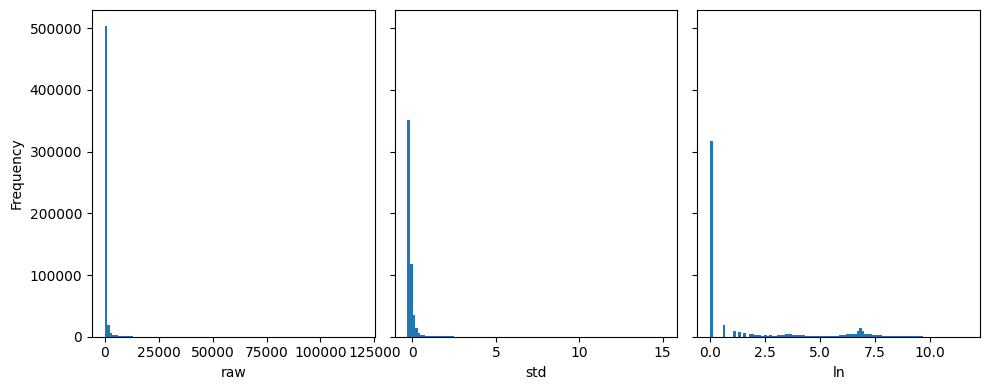

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey='row')
for ax, datatype in zip(axes, ['raw', 'std', 'ln']):
    ax.hist(data[datatype], bins=100)
    ax.set_xlabel(datatype)

axes[0].set_ylabel('Frequency')
plt.tight_layout();

# Next step?
Hsuan-Tien suggested me to fix any error or weirdness in the pilot study before moving on to the whole dataset. Those observed problems are listed below:
1.  The model couldn't converge.
2.  The model couldn't predict the extreme high counts.
3.  The model had bad predictions on the unmasked parts. BTW, this didn't happen when the transformer in the model was replaced by fully connected layers.

After testing if mask ratio too high, model too complex, data too noisy, learning rate too small, data variance too large or too skewed, I found that the model couldn't converge because the data variance was too large. Hence, by adjusting learning rate or normalizing data, the model converges. The bad prediction of extrem high counts is consequently solved. The skewness of the data is relatively minor comparing to the variance because the standardization, which can't deal with the skewness, works better than the logrithm transformation, which can deal with the skewness. The bad prediction on the unmasked parts is fixed by including the unmasked parts of spectrum into the loss function. The optimal model has overcome all the problems mentioned above and has exellent performance in the validation set. It has only 5% MSE of the first model without converging and 26% MSE of the log transform model. The visualzation of the good fit of spectrum is shown in `pilot_09.ipynb`.

The optimal settings that modified from the original MAE codes:
-  Standardize data as the pre-processing step.
-  Include both unmasked and masked parts to the loss function.

The learning rate is so far constant. Those ideal models, like BERT or MAE, use variable learning rate. Perhaps, I should try variable learning rate in the future. The usefull docs are [here](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.SequentialLR.html#torch.optim.lr_scheduler.SequentialLR) and [here](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate).

Let's go for the whole dataset, then!